<a href="https://colab.research.google.com/github/nishvit/DNN/blob/master/Session_6_Assignment_B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Conv2D, Input, DepthwiseConv2D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import layers, models

In [77]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

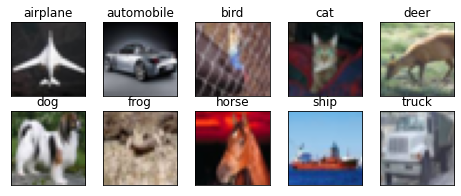

In [78]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

In [79]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [80]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [81]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)
cardinality = 32


In [82]:
from keras import layers

#define global parameters
img_width = 32
img_height = 32
img_channels = 3

def assignment_7B (x):
  
  def add_common_layers (y):
    y = layers.BatchNormalization ()(y)
    y = layers.Activation ('relu')(y)
    return y
  
  def concat (y):
    y = layers.concatenate (y)
    y = add_common_layers (y)
    return y

  def sep (y, channel_size, kernel_size, history, count):
    y = layers.SeparableConv2D(channel_size, (kernel_size, kernel_size), padding='same', use_bias=False, depthwise_initializer='glorot_uniform', pointwise_initializer='glorot_uniform')(y)
    y = add_common_layers (y)
    #index = 0
    history.append (y)
    count += 1
    return (y, history, count)
  
  def conv (y, channel_size, kernel_size, history, count):
    y = layers.Conv2D (channel_size, (kernel_size, kernel_size), strides = (1, 1), padding = 'same')(y)
    y = add_common_layers (y)
    #index = 0
    history.append (y)
    count += 1
    return (y, history, count)
    
  
  history = []
  count = -1
  
  #part 1
  (x, history, count) = sep (x, 48, 5, history, count)

  #part 2
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 3
  (x, history, count) = conv (x, 48, 5, history, count)

  #part 4
  (x, history, count) = sep (concat ([x, history[0]]), 48, 5, history, count)
  
  #part 5
  x = layers.MaxPooling2D((2, 2))(concat ([x, history[0]]))
  x = add_common_layers (x)
  history.append (x)

  #part 6
  (x, history, count) = sep (x, 48, 3, history, count)

  #part 7
  #(x, history, count) = conv (x, 48, 5, history, count)
  (x, history, count) = conv (concat ([x, layers.Reshape((16,16,48*4))(history[0]),layers.Reshape((16,16,48*4))(history[3])]), 48, 5, history, count)

  #part 8
  (x, history, count) = sep (concat ([x, layers.Reshape((16,16,48*4))(history[2]),layers.Reshape((16,16,48*4))(history[3]),history[5]]), 48, 3, history, count)

  #part 9
  (x, history, count) = sep (concat ([x, layers.Reshape((16,16,48*4))(history[0]),layers.Reshape((16,16,48*4))(history[2]),layers.Reshape((16,16,48*4))(history[3]),history[5],history[6]]), 48, 5, history, count)
  
  #part 10
  x = layers.MaxPooling2D((2, 2))(concat ([x, layers.Reshape((16,16,48*4))(history[0]),layers.Reshape((16,16,48*4))(history[3]),history[5],history[7]]))
  x = add_common_layers (x)
  history.append (x)

  #part 11
  (x, history, count) = conv (concat ([x, layers.Reshape((8,8,48*4))(history[6])]), 48, 5, history, count)

  #part 12
  (x, history, count) = sep (concat ([x, layers.Reshape((8,8,48*16))(history[1]),layers.Reshape((8,8,48*16))(history[3]),layers.Reshape((8,8,48*4))(history[7])]), 48, 5, history, count)

  #part 13
  (x, history, count) = conv (concat ([x, layers.Reshape((8,8,48*16))(history[1]),layers.Reshape((8,8,48*16))(history[2]),layers.Reshape((8,8,48*4))(history[5]),history[10]]), 48, 5, history, count)

  #part 14
  (x, history, count) = sep (concat ([x, layers.Reshape((8,8,48*16))(history[0]),layers.Reshape((8,8,48*16))(history[2]),layers.Reshape((8,8,48*16))(history[3]),layers.Reshape((8,8,48*4))(history[5]),layers.Reshape((8,8,48*4))(history[7]),history[11]]), 48, 5, history, count)
  
  #part 15 
  x = layers.Conv2D (10, (8, 8))(concat ([x, layers.Reshape((8,8,48*16))(history[3]),layers.Reshape((8,8,48*4))(history[7]),history[11]]))
  x = add_common_layers (x)
  x = layers.Flatten()(x)
  x = layers.Activation ('softmax')(x)
  history.append (x)
  
  for i, element in enumerate (history):
    print (i, element.shape)
  return x

image_tensor = layers.Input(shape=(img_height, img_width, img_channels))
network_output = assignment_7B (image_tensor)
  
model = models.Model(inputs=[image_tensor], outputs=[network_output])
print(model.summary())
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


0 (None, 32, 32, 48)
1 (None, 32, 32, 48)
2 (None, 32, 32, 48)
3 (None, 32, 32, 48)
4 (None, 16, 16, 96)
5 (None, 16, 16, 48)
6 (None, 16, 16, 48)
7 (None, 16, 16, 48)
8 (None, 16, 16, 48)
9 (None, 8, 8, 528)
10 (None, 8, 8, 48)
11 (None, 8, 8, 48)
12 (None, 8, 8, 48)
13 (None, 8, 8, 48)
14 (None, None)
Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
separable_conv2d_218 (Separable (None, 32, 32, 48)   219         input_38[0][0]                   
__________________________________________________________________________________________________
batch_normalization_692 (BatchN (None, 32, 32, 48)   192         separable_conv2d_2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras.pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 92s 235ms/step - loss: 1.4014 - accuracy: 0.5619 - val_loss: 2.4933 - val_accuracy: 0.1353
Epoch 2/100
390/390 [==============================] - 87s 222ms/step - loss: 0.9089 - accuracy: 0.7294 - val_loss: 0.9062 - val_accuracy: 0.7201
Epoch 3/100
390/390 [==============================] - 87s 222ms/step - loss: 0.6570 - accuracy: 0.8075 - val_loss: 0.8421 - val_accuracy: 0.7329
Epoch 4/100
390/390 [==============================] - 86s 222ms/step - loss: 0.4564 - accuracy: 0.8748 - val_loss: 0.8652 - val_accuracy: 0.7211
Epoch 5/100
390/390 [==============================] - 86s 221ms/step - loss: 0.2768 - accuracy: 0.9376 - val_loss: 0.8369 - val_accuracy: 0.7412
Epoch 6/100
390/390 [==============================] - 86s 221ms/step - loss: 0.1537 - accuracy: 0.9746 - val_loss: 0.9227 - val_accuracy: 0.7211
Epoch 7/100
390/390 [==============================] - 87s 222ms/step - loss: 0.0887 - accuracy: 0.9899 - val_loss: 0.7474 -

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


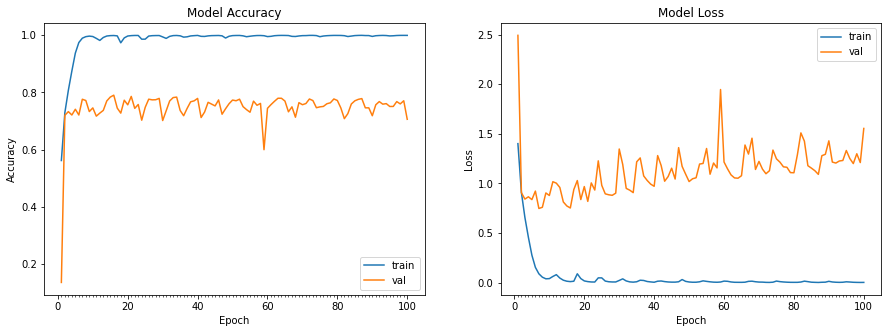

Accuracy on test data is: 70.61


In [83]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy

print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))